In [1]:
import os
import pickle
import csv
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from time import perf_counter as timer
from concurrent.futures import ProcessPoolExecutor

from src import *


In [8]:
data = Data(gamma=0)

In [23]:
gammas = np.arange(0, 0.16, 0.01)
models = ["model_1", "model_2", "model_3"]

In [25]:
smps = np.empty((len(gammas), 3, 8760)) # by gamma # by model

for idx_gamma, gamma in enumerate(gammas):
    for idx_model, model in enumerate(models):
        path_smp = data.path_data / "outputs" / f"{gamma}" / f"{model}" / "smp.npy"
        smps[idx_gamma, idx_model] = np.load(path_smp)

In [37]:
costs_energy = np.empty((len(gammas), 3, 8760)) # by gamma # by model

for idx_gamma, gamma in enumerate(gammas):
    for idx_model, model in enumerate(models):
        path_smp = data.path_data / "outputs" / f"{gamma}" / f"{model}" / "cost_energy.npy"
        smps[idx_gamma, idx_model] = np.load(path_smp)

In [38]:
costs_reserve = np.empty((len(gammas), 3, 8760)) # by gamma # by model

for idx_gamma, gamma in enumerate(gammas):
    for idx_model, model in enumerate(models):
        path_smp = data.path_data / "outputs" / f"{gamma}" / f"{model}" / "cost_reserve.npy"
        smps[idx_gamma, idx_model] = np.load(path_smp)

In [39]:
idx_hour_start, idx_hour_end = 0, 743 # end not inclusive due to slicing

In [41]:
np.all((costs_energy[:, 2, :] - costs_energy[:, 1, :]) == 0)

np.True_

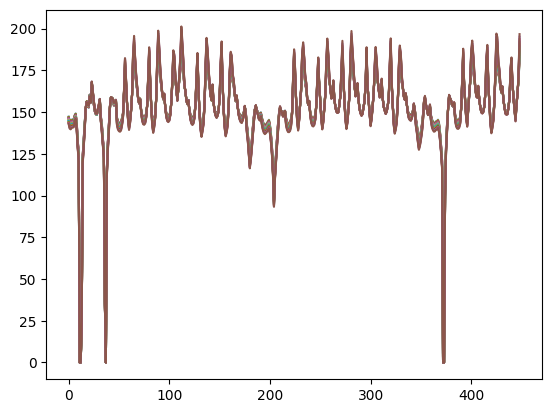

In [ ]:
fig, ax = plt.subplot(1, 1, figsize=(10, 10))

for smp in smps[:, 2, ]

plt.show(fig)

In [5]:
smp_real = data.get_smp_real()

In [6]:
# for monthly plots
month_names = {0: "January", 1: "February", 2: "March", 3: "April", 4: "May", 5: "June", 6: "July", 7: "August", 8: "September", 9: "October", 10: "November", 11: "December"}
idxs_hour_month_start = np.array([0, 744, 1416, 2160, 2880, 3624, 4344, 5088, 5832, 6552, 7296, 8016])
idxs_hour_month_end = np.concatenate((np.delete(idxs_hour_month_start, 0), np.array([8760]))) - 1
iterators_month = [range(start, (end + 1)) for start, end in zip(idxs_hour_month_start, idxs_hour_month_end)]
days_in_months = np.array([31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31])
# np.searchsorted(idxs_hour_month_start, idx_hour, side='right') - 1 # returns 0-index month given idx_hour

# for day plots
day_names = {0: "Monday", 1: "Tuesday", 2: "Wednesday", 3: "Thursday", 4: "Friday", 5: "Saturday", 6: "Sunday"}
days_of_year = (np.arange(8760) // 24 + 5) % 7
days_cmap = days_cmap = [plt.colormaps["jet_r"](i / 6) for i in range(7)]



<BarContainer object of 8760 artists>

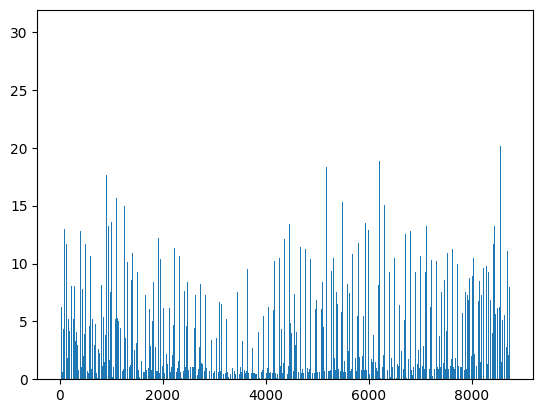

In [11]:
plt.bar(range(8760), (result_3.smp - result_2.smp))

In [8]:
# from copy import deepcopy
# result_3_reserve = deepcopy(result_3.smp)

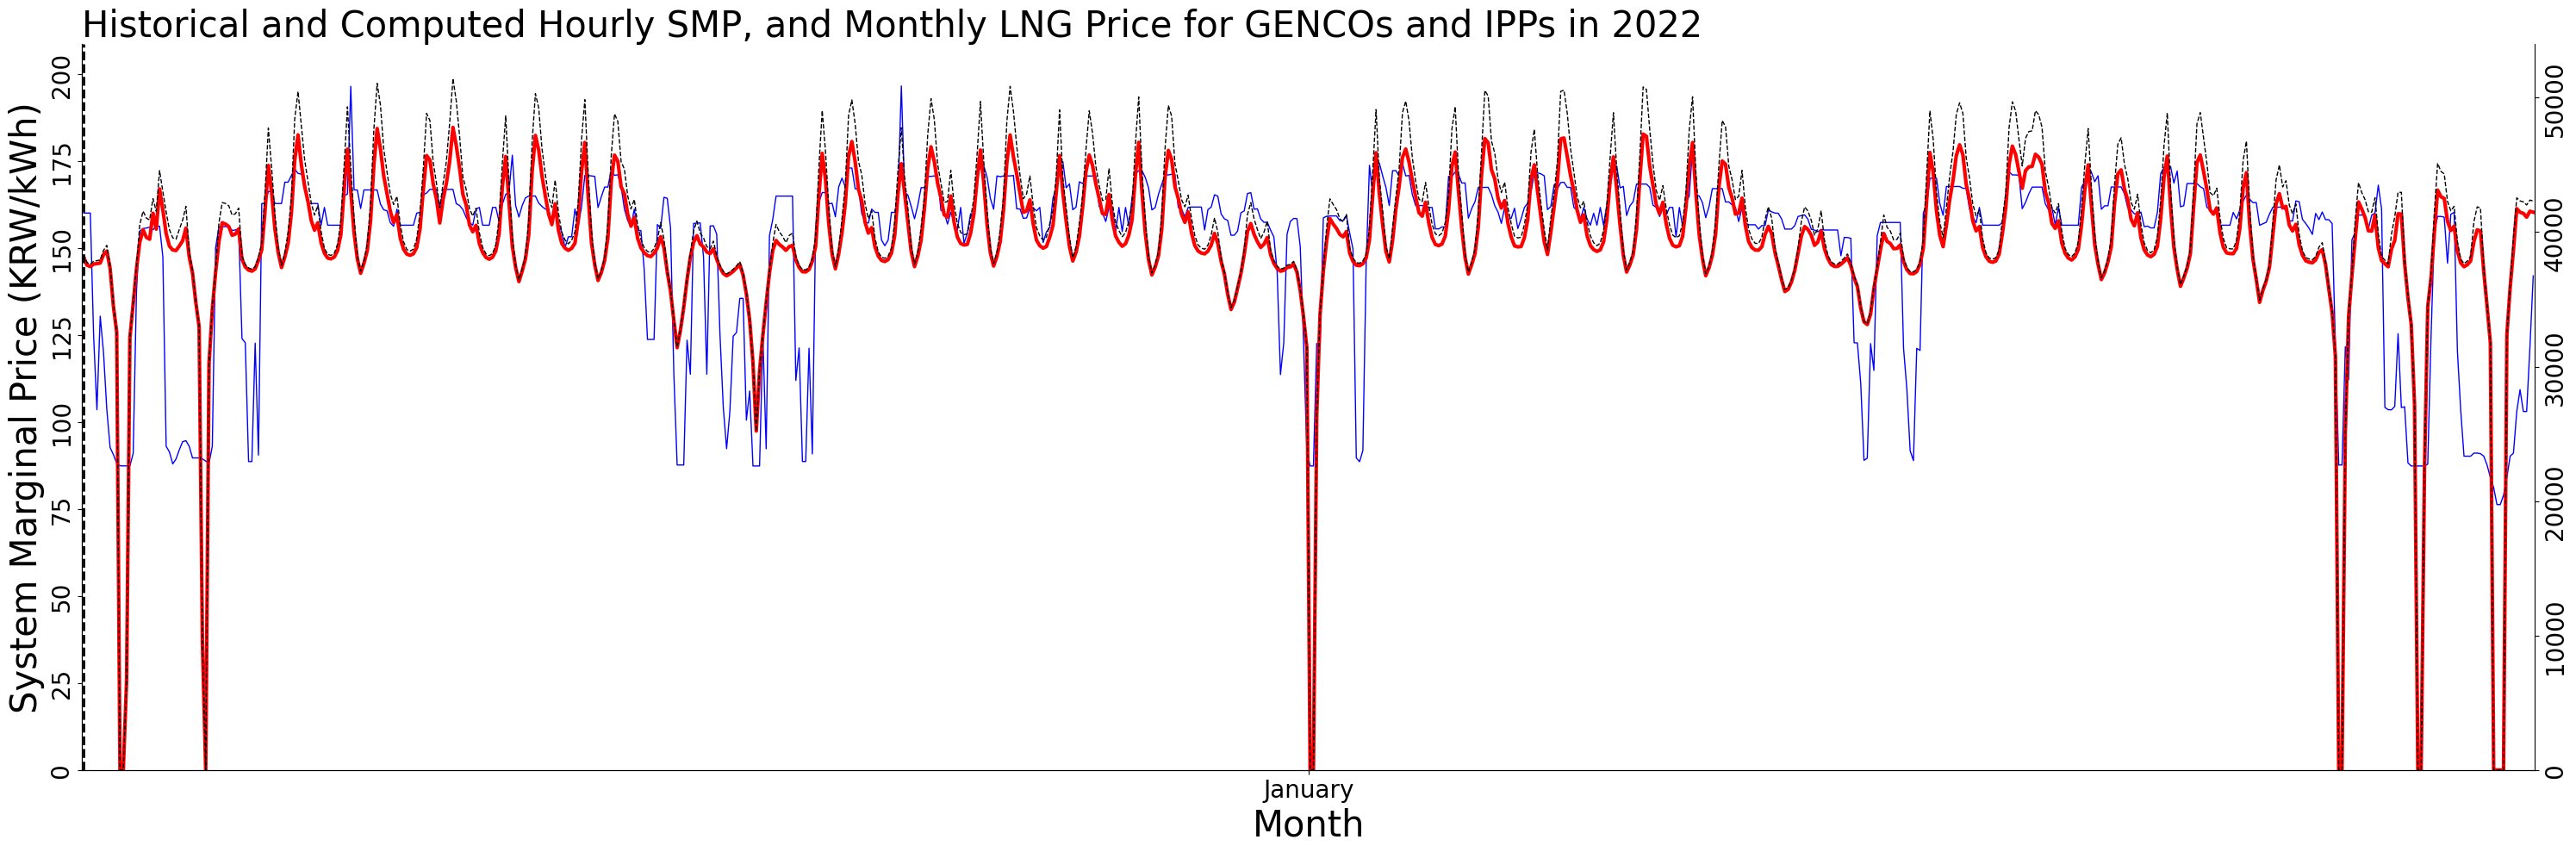

In [12]:
idx_hour_spc_start, idx_hour_spc_end = idxs_hour_month_start[0], idxs_hour_month_end[0]
iterator = range(idx_hour_spc_start, (idx_hour_spc_end + 1))

fig, ax1 = plt.subplots(1, 1, figsize=(30, 10))
ax2 = ax1.twinx()
# SMP
l0, = ax1.plot(iterator, smp_real[idx_hour_spc_start:idx_hour_spc_end+1], color="blue", label="SMP - KPX", linewidth=1)
l1, = ax1.plot(iterator, result_2.smp[idx_hour_spc_start:idx_hour_spc_end+1], color="red", label="SMP - GYEONGMIN", linewidth=3)
# l1, = ax1.plot(iterator, result_3_reserve.smp[idx_hour_spc_start:idx_hour_spc_end+1], color="green", label="SMP - GYEONGMIN", linewidth=1, linestyle="--")
l1, = ax1.plot(iterator, result_3.smp[idx_hour_spc_start:idx_hour_spc_end+1], color="black", label="SMP - GYEONGMIN", linewidth=1, linestyle="--")

# MONTH
ymin, ymax = ax1.get_ylim()
ymin = ymin if result_2.smp[idx_hour_spc_start:idx_hour_spc_end+1].min() < 0 else 0
l3= ax1.vlines(x=idxs_hour_month_start.tolist() + [idxs_hour_month_end[-1]], ymin=ymin, ymax=ymax, colors="black", linewidth=2, linestyles="--", label="New Month")
# TITLE
ax1.set_title("Historical and Computed Hourly SMP, and Monthly LNG Price for GENCOs and IPPs in 2022",
              fontsize=30, loc='left')
ax1.set_xlabel("Month", fontsize=30)
ax1.set_ylabel("System Marginal Price (KRW/kWh)", fontsize=30)
# ax2.set_ylabel("LNG Price (KRW/GJ)", fontsize=30)
# TICKS
ax1.set_xticks(((idxs_hour_month_start + idxs_hour_month_end) / 2).tolist())
ax1.set_xticklabels(list(month_names.values()))
ax1.tick_params(axis='both', labelsize=20)
[label.set_rotation(90) or label.set_va('center') for label in ax1.get_yticklabels()]
[label.set_rotation(90) or label.set_va('center') or label.set_fontsize(20) for label in ax2.get_yticklabels()]
# LEGEND
lines = [l0, l1, l3]
# ax1.legend(lines, [line.get_label() for line in lines], loc="upper left", fontsize=20)
# LIM
ax1.set_xlim((idx_hour_spc_start - 0.5, idx_hour_spc_end + .5))
ax1.set_ylim((ymin, ymax))
ax2.set_ylim((0, 54000))


ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)


fig.tight_layout()
plt.show(fig) # LNG price is basically for justification of the method for tuning (development of method 2) # why it's sensible to scale the LNG's C1 by alpha (below)